In [1]:
# -*- coding: utf-8 -*-

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from imageio import imread, imsave, mimsave
import glob
import os
from tqdm import tqdm

In [2]:
images = glob.glob('data/train/*.jpg')
print(len(images))

49825


In [3]:
img = imread(images[0])

In [4]:
img.shape

(256, 512, 3)

(-0.5, 511.5, 255.5, -0.5)

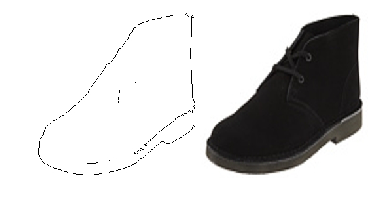

In [5]:
plt.imshow(img)
plt.axis("off")

In [ ]:
X_all = []
Y_all = []
WIDTH = 256
HEIGHT = 256
for image in images:
    img = imread(image)
    img = (img / 255. - 0.5) * 2 #这个你可以认为把数据变换到了-1到1
    # B2A
    X_all.append(img[:, WIDTH:, :])
    Y_all.append(img[:, :WIDTH, :])
X_all = np.array(X_all)
Y_all = np.array(Y_all)
print(X_all.shape, Y_all.shape)

In [6]:
batch_size = 1
LAMBDA = 100
WIDTH = 256
HEIGHT = 256
OUTPUT_DIR = 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

X = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='X')
Y = tf.placeholder(dtype=tf.float32, shape=[None, HEIGHT, WIDTH, 3], name='Y')
k_initializer = tf.random_normal_initializer(0, 0.02)
g_initializer = tf.random_normal_initializer(1, 0.02)

def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)

def d_conv(inputs, filters, strides):
    padded = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='CONSTANT')
    return tf.layers.conv2d(padded, kernel_size=4, filters=filters, strides=strides, padding='valid', kernel_initializer=k_initializer)

def g_conv(inputs, filters):
    return tf.layers.conv2d(inputs, kernel_size=4, filters=filters, strides=2, padding='same', kernel_initializer=k_initializer)
    
def g_deconv(inputs, filters):
    return tf.layers.conv2d_transpose(inputs, kernel_size=4, filters=filters, strides=2, padding='same', kernel_initializer=k_initializer)

def batch_norm(inputs):
    return tf.layers.batch_normalization(inputs, axis=3, epsilon=1e-5, momentum=0.1, training=True, gamma_initializer=g_initializer)

def sigmoid_cross_entropy_with_logits(x, y):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y) 

In [7]:
def discriminator(x, y, reuse=None):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.concat([x, y], axis=3)    
        h0 = lrelu(d_conv(x, 64, 2)) # 128 128 64
        
        h0 = d_conv(h0, 128, 2)
        h0 = lrelu(batch_norm(h0)) # 64 64 128
        
        h0 = d_conv(h0, 256, 2)
        h0 = lrelu(batch_norm(h0)) # 32 32 256
        
        h0 = d_conv(h0, 512, 1)
        h0 = lrelu(batch_norm(h0)) # 31 31 512
        
        logit = d_conv(h0, 1, 1) # 30 30 1
        singmoid_logit = tf.nn.sigmoid(logit) #这个就是patch gan的思想。
        
        return logit,singmoid_logit

In [8]:
def generator(x):
    with tf.variable_scope('generator', reuse=None):
        layers = []
        h0 = g_conv(x, 64)
        layers.append(h0)
        
        for filters in [128, 256, 512, 512, 512, 512, 512]:
            h0 = lrelu(layers[-1])
            h0 = g_conv(h0, filters)
            h0 = batch_norm(h0)
            layers.append(h0)
        
        encode_layers_num = len(layers) # 8
        
        for i, filters in enumerate([512, 512, 512, 512, 256, 128, 64]):
            skip_layer = encode_layers_num - i - 1
            if i == 0:
                inputs = layers[-1]
            else:
                inputs = tf.concat([layers[-1], layers[skip_layer]], axis=3)#这里是拼接上去，并不是加和
            h0 = tf.nn.relu(inputs)
            h0 = g_deconv(h0, filters)
            h0 = batch_norm(h0)
            if i < 3:
                h0 = tf.nn.dropout(h0, keep_prob=0.5)
            layers.append(h0)
        
        inputs = tf.concat([layers[-1], layers[0]], axis=3)
        h0 = tf.nn.relu(inputs)
        h0 = g_deconv(h0, 3)
        h0 = tf.nn.tanh(h0, name='g')
        return h0

In [9]:
g = generator(X)
d_real,d_real_sigmoid = discriminator(X, Y)
d_fake,d_fake_sigmoid = discriminator(X, g, reuse=True)

vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

loss_d_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_real, tf.ones_like(d_real_sigmoid)))
loss_d_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake, tf.zeros_like(d_fake_sigmoid)))
loss_d = loss_d_real + loss_d_fake

loss_g_gan = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake, tf.ones_like(d_fake)))
loss_g_l1 = tf.reduce_mean(tf.abs(Y - g))
loss_g = loss_g_gan + loss_g_l1 * LAMBDA

In [10]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5).minimize(loss_g, var_list=vars_g)

In [11]:
m = [1,2,3]
np.random.shuffle(m)
print(m)

[1, 2, 3]


In [12]:
saver = tf.train.Saver(tf.global_variables())

INFO:tensorflow:Restoring parameters from ./pix2pix_diy-100000


  0%|                                                                               | 0/49825 [00:00<?, ?it/s]

0 2.2352476 13.4542675


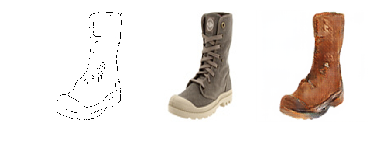

generator loss 28.736042 discriminator loss 1.6837853:   2%|▏          | 1000/49825 [04:44<3:51:29,  3.52it/s]

1000 1.1346382 13.130689


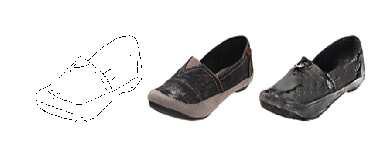

generator loss 11.763964 discriminator loss 1.0469762:   4%|▍          | 2000/49825 [09:24<3:44:54,  3.54it/s]

2000 0.67906785 19.079292


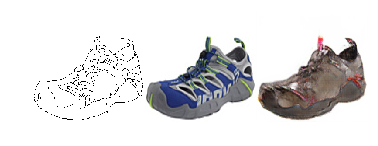

generator loss 6.228794 discriminator loss 1.0815802:   6%|▋           | 3000/49825 [14:03<3:39:25,  3.56it/s]

3000 0.52799475 7.5320234


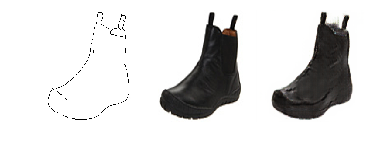

generator loss 14.567778 discriminator loss 0.7686694:   8%|▉          | 4000/49825 [18:40<3:34:01,  3.57it/s]

4000 0.41841713 28.11116


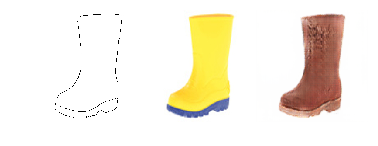

generator loss 15.064771 discriminator loss 1.602967:  10%|█▏          | 5000/49825 [23:18<3:28:55,  3.58it/s]

5000 0.88956517 9.089157


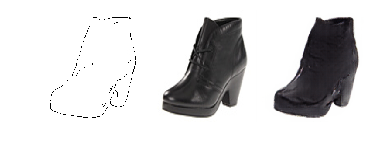

generator loss 16.38027 discriminator loss 0.6276237:  12%|█▍          | 6000/49825 [27:55<3:23:58,  3.58it/s]

6000 0.037971817 22.342905


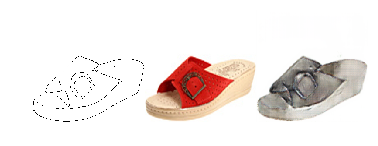

generator loss 17.186844 discriminator loss 1.0358526:  14%|█▌         | 7000/49825 [32:33<3:19:13,  3.58it/s]

7000 0.6465363 13.813185


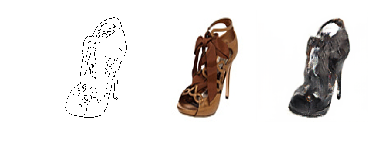

generator loss 12.569647 discriminator loss 0.6239108:  16%|█▊         | 8000/49825 [37:11<3:14:24,  3.59it/s]

8000 1.1579083 12.05156


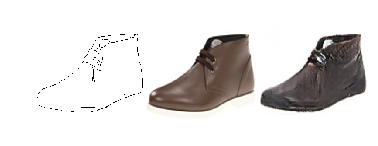

generator loss 26.420164 discriminator loss 0.9944669:  18%|█▉         | 9000/49825 [41:48<3:09:37,  3.59it/s]

9000 0.7051535 5.0184765


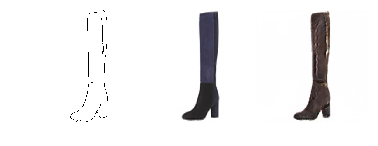

generator loss 25.754057 discriminator loss 0.23736337:  20%|█▊       | 10000/49825 [46:25<3:04:52,  3.59it/s]

10000 0.5816186 31.826515


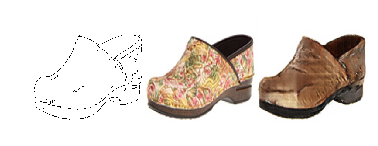

generator loss 9.648745 discriminator loss 0.24548452:  22%|██▏       | 11000/49825 [51:02<3:00:08,  3.59it/s]

11000 0.6740303 8.167313


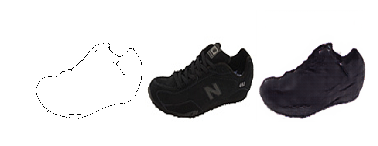

generator loss 17.866623 discriminator loss 0.16379258:  24%|██▏      | 12000/49825 [55:39<2:55:26,  3.59it/s]

12000 0.3910931 20.263855


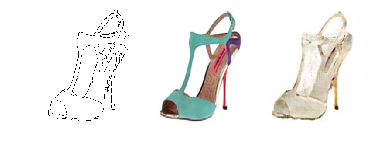

generator loss 14.381326 discriminator loss 1.2669799:  26%|██      | 13000/49825 [1:00:17<2:50:45,  3.59it/s]

13000 0.30894718 11.584655


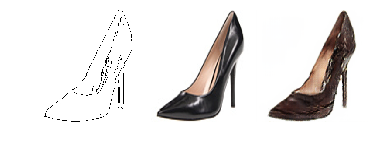

generator loss 11.000101 discriminator loss 0.43369362:  28%|█▉     | 14000/49825 [1:04:54<2:46:05,  3.60it/s]

14000 0.4323445 9.199746


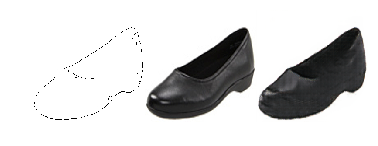

generator loss 8.403595 discriminator loss 0.17338048:  30%|██▍     | 15000/49825 [1:09:31<2:41:24,  3.60it/s]

15000 0.6417436 13.87178


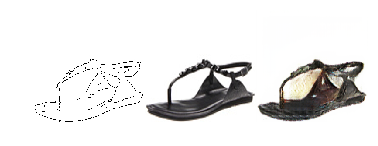

generator loss 20.965733 discriminator loss 0.15529993:  32%|██▏    | 16000/49825 [1:14:08<2:36:44,  3.60it/s]

16000 0.72711354 17.028254


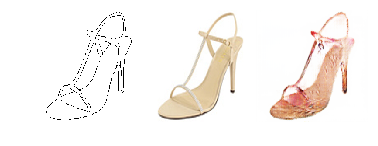

generator loss 23.14104 discriminator loss 0.37399563:  34%|██▋     | 17000/49825 [1:18:45<2:32:04,  3.60it/s]

17000 0.21890599 12.890383


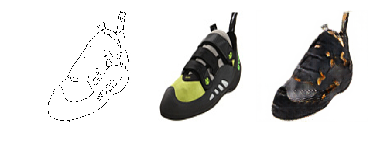

generator loss 10.705579 discriminator loss 0.50962293:  36%|██▌    | 18000/49825 [1:23:22<2:27:25,  3.60it/s]

18000 0.36809123 13.140049


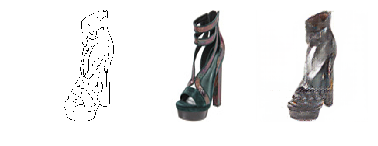

generator loss 16.401718 discriminator loss 0.30561566:  38%|██▋    | 19000/49825 [1:28:00<2:22:46,  3.60it/s]

19000 0.3602605 28.33001


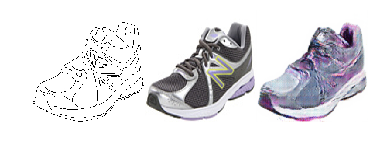

generator loss 24.185389 discriminator loss 0.056720193:  40%|██▍   | 20000/49825 [1:32:37<2:18:07,  3.60it/s]

20000 0.38355574 14.453424


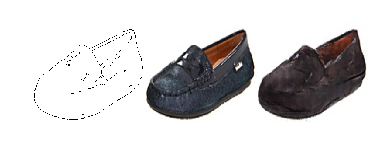

generator loss 30.290981 discriminator loss 0.52684927:  42%|██▉    | 21000/49825 [1:37:14<2:13:28,  3.60it/s]

21000 0.5722052 30.654394


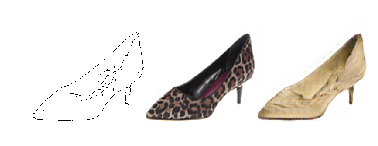

generator loss 16.23948 discriminator loss 0.19607908:  44%|███▌    | 22000/49825 [1:41:51<2:08:49,  3.60it/s]

22000 1.0907458 11.024261


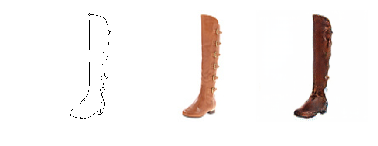

generator loss 13.965643 discriminator loss 0.88151205:  46%|███▏   | 23000/49825 [1:46:28<2:04:11,  3.60it/s]

23000 0.23419288 17.283564


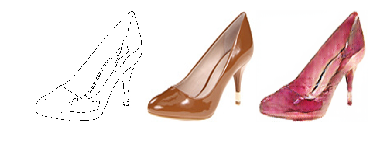

generator loss 7.9741144 discriminator loss 0.6844624:  48%|███▊    | 24000/49825 [1:51:05<1:59:32,  3.60it/s]

24000 0.70318586 24.360119


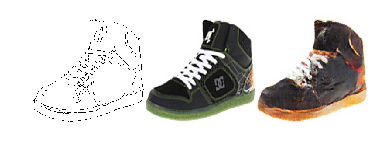

generator loss 10.509851 discriminator loss 0.31278327:  50%|███▌   | 25000/49825 [1:55:42<1:54:54,  3.60it/s]

25000 1.3787786 12.854521


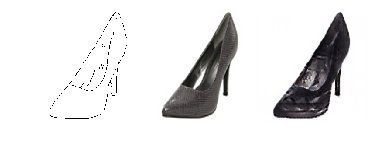

generator loss 30.06551 discriminator loss 0.290143:  52%|█████▏    | 26000/49825 [2:00:20<1:50:16,  3.60it/s]

26000 0.7476537 13.650638


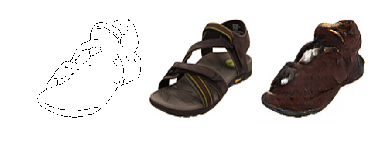

generator loss 16.98965 discriminator loss 0.4005249:  54%|████▉    | 27000/49825 [2:04:57<1:45:37,  3.60it/s]

27000 0.10475005 16.147116


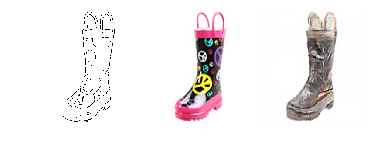

generator loss 10.833335 discriminator loss 0.5842277:  56%|████▍   | 28000/49825 [2:09:34<1:40:59,  3.60it/s]

28000 0.08085167 20.349232


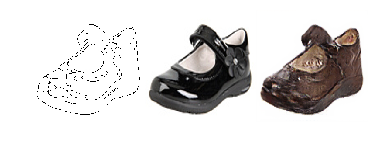

generator loss 22.595615 discriminator loss 0.16939044:  58%|████   | 29000/49825 [2:14:11<1:36:21,  3.60it/s]

29000 0.47639626 18.169271


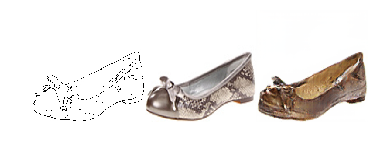

generator loss 14.099978 discriminator loss 1.4204792:  60%|████▊   | 30000/49825 [2:18:48<1:31:43,  3.60it/s]

30000 0.25602168 17.699612


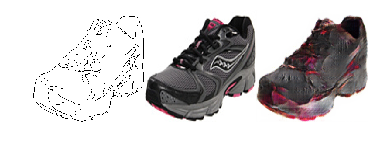

generator loss 16.740414 discriminator loss 0.17761888:  62%|████▎  | 31000/49825 [2:23:25<1:27:05,  3.60it/s]

31000 1.0298487 17.040228


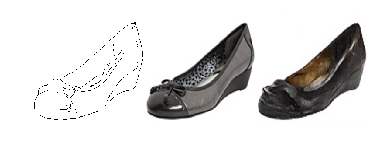

generator loss 10.728717 discriminator loss 0.60992426:  64%|████▍  | 32000/49825 [2:28:02<1:22:27,  3.60it/s]

32000 0.142546 20.723928


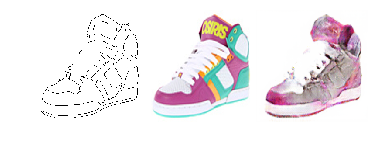

generator loss 24.991058 discriminator loss 1.2741114:  66%|█████▎  | 33000/49825 [2:32:39<1:17:49,  3.60it/s]

33000 0.7177272 18.582615


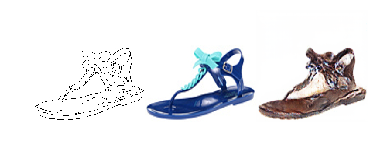

generator loss 12.868062 discriminator loss 0.51670074:  68%|████▊  | 34000/49825 [2:37:16<1:13:12,  3.60it/s]

34000 0.10601953 15.90242


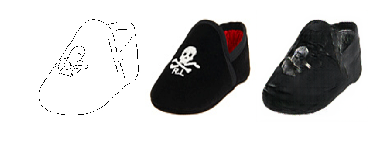

generator loss 16.522013 discriminator loss 0.7722378:  70%|█████▌  | 35000/49825 [2:41:53<1:08:34,  3.60it/s]

35000 1.6325732 5.5754375


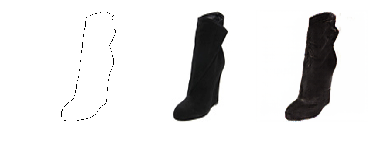

generator loss 14.141274 discriminator loss 0.24083096:  72%|█████  | 36000/49825 [2:46:30<1:03:56,  3.60it/s]

36000 0.33074635 19.343481


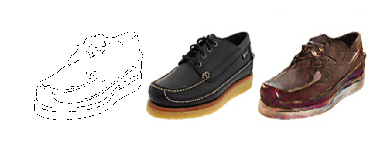

generator loss 32.739056 discriminator loss 0.13094938:  74%|██████▋  | 37000/49825 [2:51:07<59:19,  3.60it/s]

37000 1.3501321 8.846273


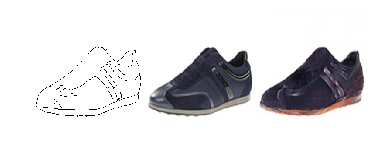

generator loss 13.807691 discriminator loss 0.12610385:  76%|██████▊  | 38000/49825 [2:55:44<54:41,  3.60it/s]

38000 0.07716691 22.344929


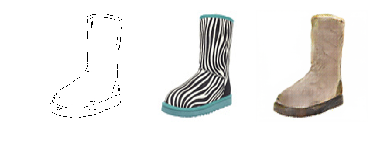

generator loss 14.905865 discriminator loss 0.35514244:  78%|███████  | 39000/49825 [3:00:22<50:04,  3.60it/s]

39000 0.4776622 7.679544


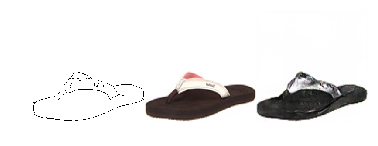

generator loss 14.503779 discriminator loss 1.5301082:  80%|████████  | 40000/49825 [3:04:59<45:26,  3.60it/s]

40000 0.086573675 18.853243


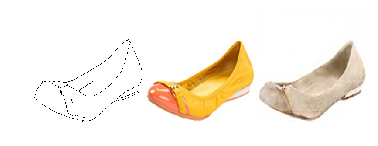

generator loss 6.283989 discriminator loss 0.69732034:  82%|████████▏ | 41000/49825 [3:09:37<40:48,  3.60it/s]

41000 0.87600267 10.876688


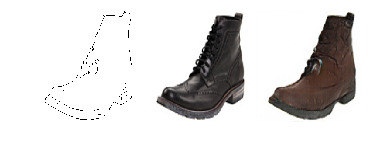

generator loss 11.306357 discriminator loss 0.26426196:  84%|███████▌ | 42000/49825 [3:14:14<36:11,  3.60it/s]

42000 1.6915717 7.8912144


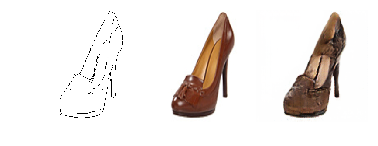

generator loss 44.17841 discriminator loss 0.111062646:  86%|███████▊ | 43000/49825 [3:18:51<31:33,  3.60it/s]

43000 1.898759 5.549735


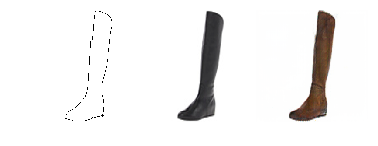

generator loss 9.920475 discriminator loss 1.7006528:  88%|█████████▋ | 44000/49825 [3:23:28<26:56,  3.60it/s]

44000 0.30331457 7.5960655


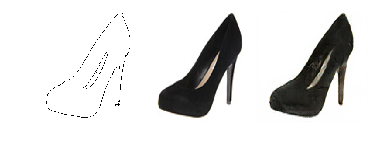

generator loss 20.02823 discriminator loss 0.058826327:  90%|████████▏| 45000/49825 [3:28:05<22:18,  3.60it/s]

45000 0.029795606 21.752697


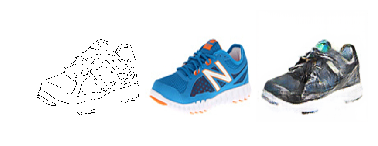

generator loss 9.751427 discriminator loss 0.43396562:  92%|█████████▏| 46000/49825 [3:32:42<17:41,  3.60it/s]

46000 0.11003786 28.748325


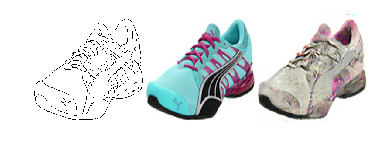

generator loss 7.287671 discriminator loss 1.1570433:  94%|██████████▍| 47000/49825 [3:37:19<13:03,  3.60it/s]

47000 0.26974595 10.621668


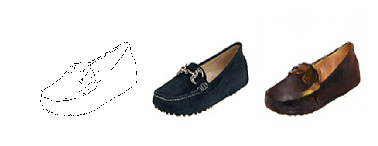

generator loss 23.89792 discriminator loss 0.020181898:  96%|████████▋| 48000/49825 [3:41:57<08:26,  3.60it/s]

48000 0.15996565 24.524658


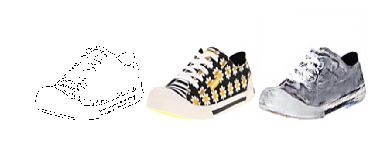

generator loss 4.069127 discriminator loss 1.4434688:  98%|██████████▊| 49000/49825 [3:46:34<03:48,  3.60it/s]

49000 1.7424666 14.972203


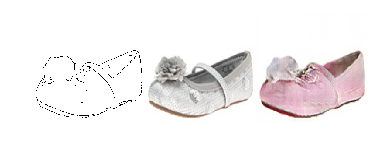

generator loss 25.13962 discriminator loss 0.13133897: 100%|██████████| 49825/49825 [3:50:22<00:00,  3.60it/s]
  0%|                                                                               | 0/49825 [00:00<?, ?it/s]

0 0.24526784 18.769691


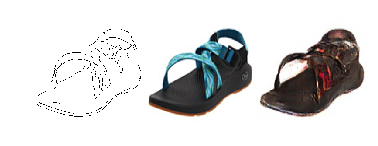

generator loss 24.161089 discriminator loss 1.422006:   2%|▏           | 1000/49825 [04:36<3:45:11,  3.61it/s]

1000 1.4734719 6.763751


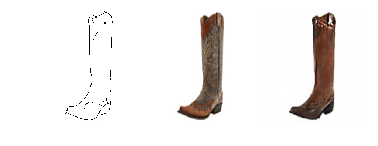

generator loss 19.170256 discriminator loss 0.7192725:   4%|▍          | 2000/49825 [09:13<3:40:33,  3.61it/s]

2000 0.6743555 14.9456215


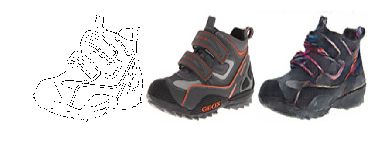

generator loss 14.428419 discriminator loss 0.17232433:   6%|▌         | 3000/49825 [13:50<3:35:57,  3.61it/s]

3000 1.1484548 9.681171


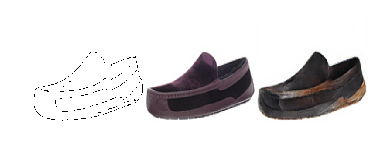

generator loss 30.181955 discriminator loss 0.56911016:   8%|▊         | 4000/49825 [18:26<3:31:21,  3.61it/s]

4000 0.17759493 31.100716


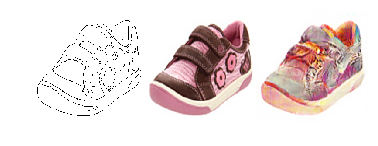

generator loss 9.6982155 discriminator loss 0.86585563:  10%|█         | 5000/49825 [23:03<3:26:44,  3.61it/s]

5000 1.0256245 10.952881


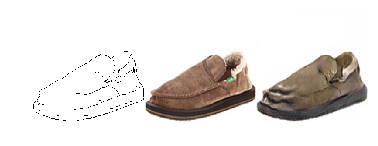

generator loss 13.731915 discriminator loss 0.37461865:  12%|█▏        | 6000/49825 [27:40<3:22:08,  3.61it/s]

6000 2.198254 5.7558413


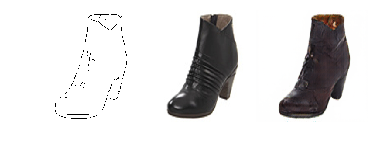

generator loss 11.087586 discriminator loss 0.9110448:  14%|█▌         | 7000/49825 [32:17<3:17:32,  3.61it/s]

7000 1.2477976 7.2440243


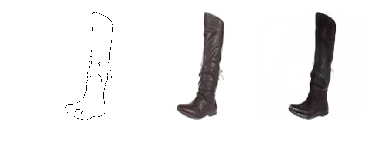

generator loss 8.742646 discriminator loss 0.75509536:  16%|█▊         | 8000/49825 [36:53<3:12:54,  3.61it/s]

8000 0.9830443 11.838009


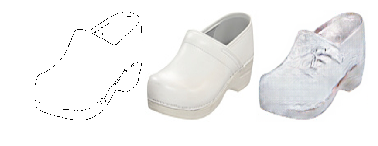

generator loss 11.371269 discriminator loss 1.271325:  18%|██▏         | 9000/49825 [41:30<3:08:18,  3.61it/s]

9000 0.66476095 22.441772


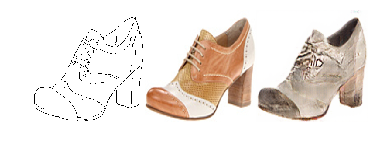

generator loss 14.305417 discriminator loss 0.7868193:  20%|██        | 10000/49825 [46:07<3:03:41,  3.61it/s]

10000 0.7024485 6.231783


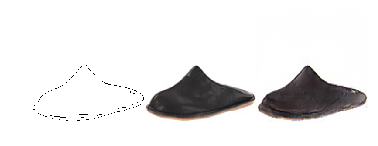

generator loss 18.137836 discriminator loss 0.15609217:  22%|█▉       | 11000/49825 [50:44<2:59:05,  3.61it/s]

11000 0.012004968 17.23096


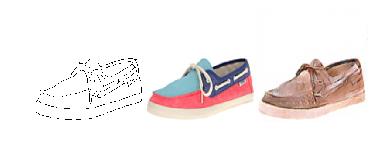

generator loss 26.185778 discriminator loss 1.8009628:  24%|██▍       | 12000/49825 [55:21<2:54:28,  3.61it/s]

12000 0.45742714 12.273917


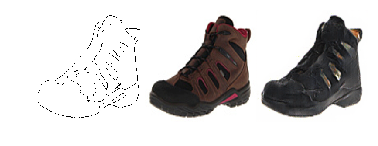

generator loss 10.885719 discriminator loss 1.1604406:  26%|██▌       | 13000/49825 [59:57<2:49:51,  3.61it/s]

13000 0.6470024 16.92142


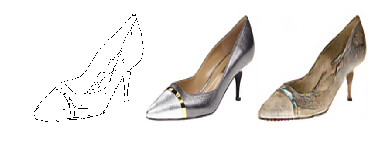

generator loss 17.051456 discriminator loss 0.503606:  28%|██▌      | 14000/49825 [1:04:34<2:45:14,  3.61it/s]

14000 0.941087 6.170128


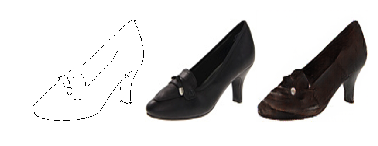

generator loss 18.288374 discriminator loss 0.25320774:  30%|██     | 15000/49825 [1:09:11<2:40:37,  3.61it/s]

15000 0.8269806 16.981323


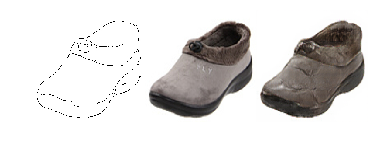

generator loss 13.594864 discriminator loss 0.38105643:  32%|██▏    | 16000/49825 [1:13:47<2:36:00,  3.61it/s]

16000 2.0443745 11.594174


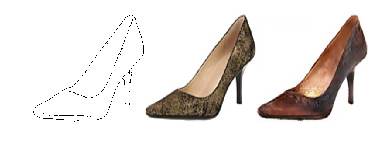

generator loss 13.391867 discriminator loss 0.73574895:  34%|██▍    | 17000/49825 [1:18:24<2:31:24,  3.61it/s]

17000 0.28139478 15.782689


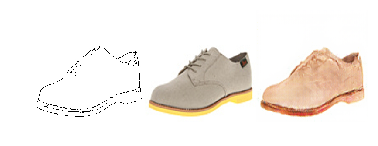

generator loss 8.397104 discriminator loss 0.7455792:  36%|███▎     | 18000/49825 [1:23:01<2:26:47,  3.61it/s]

18000 0.49615705 9.386648


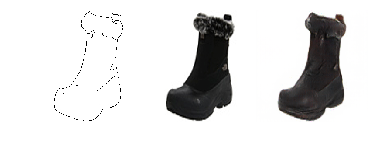

generator loss 24.774382 discriminator loss 0.020267408:  38%|██▎   | 19000/49825 [1:27:38<2:22:10,  3.61it/s]

19000 0.1724254 12.162219


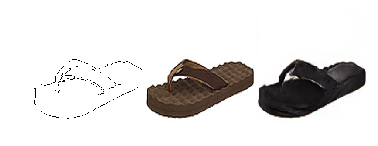

generator loss 19.795074 discriminator loss 0.26006475:  40%|██▊    | 20000/49825 [1:32:14<2:17:33,  3.61it/s]

20000 1.0243797 6.8177557


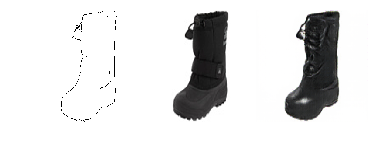

generator loss 10.347714 discriminator loss 0.94380164:  42%|██▉    | 21000/49825 [1:36:51<2:12:56,  3.61it/s]

21000 0.5876989 9.226572


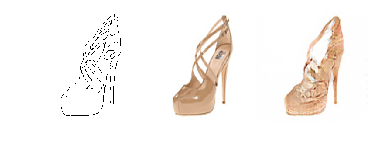

generator loss 11.447121 discriminator loss 1.343924:  44%|███▉     | 22000/49825 [1:41:27<2:08:19,  3.61it/s]

22000 0.5798179 6.7857924


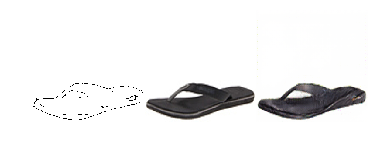

generator loss 11.083703 discriminator loss 0.16956511:  46%|███▏   | 23000/49825 [1:46:04<2:03:42,  3.61it/s]

23000 0.836014 8.37438


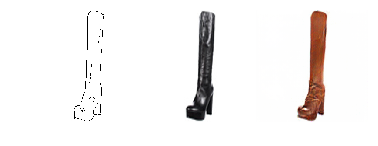

generator loss 9.870006 discriminator loss 1.0667549:  48%|████▎    | 24000/49825 [1:50:41<1:59:06,  3.61it/s]

24000 0.22961147 16.419998


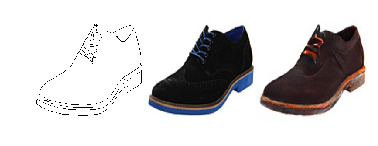

generator loss 15.142399 discriminator loss 0.21387097:  50%|███▌   | 25000/49825 [1:55:17<1:54:29,  3.61it/s]

25000 0.14204872 25.210503


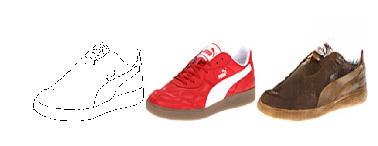

generator loss 26.565544 discriminator loss 0.39650485:  52%|███▋   | 26000/49825 [1:59:54<1:49:52,  3.61it/s]

26000 0.69448364 7.438042


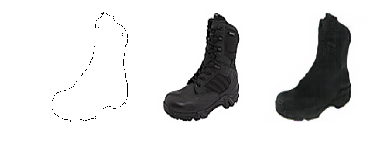

generator loss 7.003395 discriminator loss 1.3694916:  54%|████▉    | 27000/49825 [2:04:31<1:45:16,  3.61it/s]

27000 2.0418808 8.922347


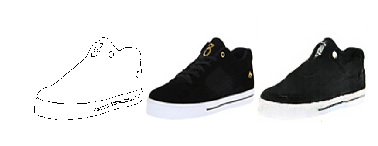

generator loss 22.902739 discriminator loss 0.14827497:  56%|███▉   | 28000/49825 [2:09:08<1:40:39,  3.61it/s]

28000 0.45398778 14.409895


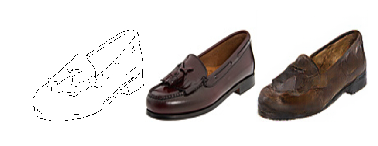

generator loss 12.021639 discriminator loss 0.12645908:  58%|████   | 29000/49825 [2:13:45<1:36:02,  3.61it/s]

29000 0.72467005 8.897738


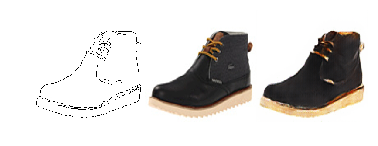

generator loss 6.994594 discriminator loss 0.86017644:  60%|████▊   | 30000/49825 [2:18:21<1:31:26,  3.61it/s]

30000 0.49139792 6.3451023


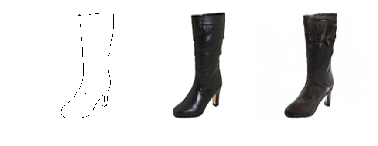

generator loss 11.730129 discriminator loss 1.5963693:  62%|████▉   | 31000/49825 [2:22:58<1:26:49,  3.61it/s]

31000 1.1404082 5.536212


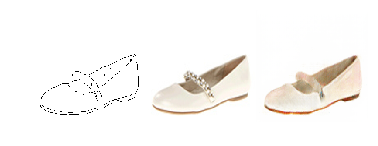

generator loss 14.368072 discriminator loss 2.000736:  64%|█████▊   | 32000/49825 [2:27:35<1:22:12,  3.61it/s]

32000 1.0967479 24.390043


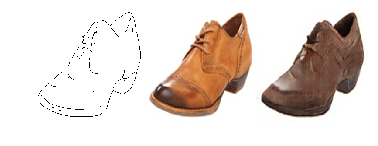

generator loss 14.504245 discriminator loss 0.23628154:  66%|████▋  | 33000/49825 [2:32:11<1:17:35,  3.61it/s]

33000 0.26521146 7.753475


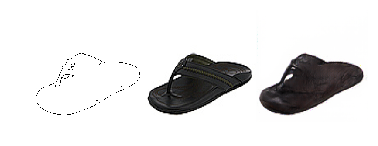

generator loss 23.130486 discriminator loss 0.13030368:  68%|████▊  | 34000/49825 [2:36:48<1:12:59,  3.61it/s]

34000 0.33741128 16.777674


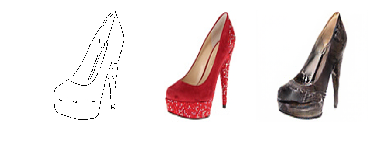

generator loss 3.811306 discriminator loss 1.6290134:  70%|██████▎  | 35000/49825 [2:41:25<1:08:22,  3.61it/s]

35000 1.1723872 13.179953


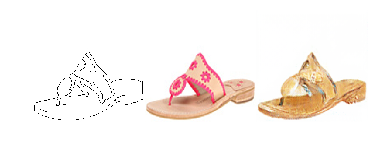

generator loss 11.363417 discriminator loss 0.84435767:  72%|█████  | 36000/49825 [2:46:02<1:03:45,  3.61it/s]

36000 0.28324294 11.645764


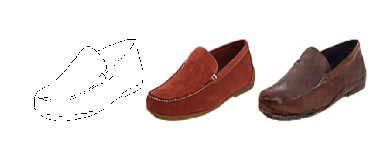

generator loss 5.2037115 discriminator loss 0.6811566:  74%|███████▍  | 37000/49825 [2:50:38<59:08,  3.61it/s]

37000 0.0874747 18.154247


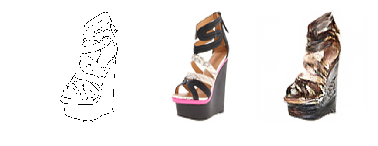

generator loss 31.329391 discriminator loss 0.04529755:  76%|██████▊  | 38000/49825 [2:55:15<54:32,  3.61it/s]

38000 0.41810292 9.475267


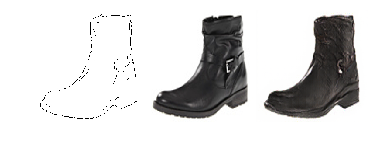

generator loss 9.694399 discriminator loss 1.925498:  78%|█████████▍  | 39000/49825 [2:59:52<49:55,  3.61it/s]

39000 0.3018132 10.298874


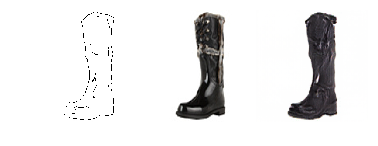

generator loss 17.889389 discriminator loss 0.45857716:  80%|███████▏ | 40000/49825 [3:04:29<45:18,  3.61it/s]

40000 0.37814552 12.065527


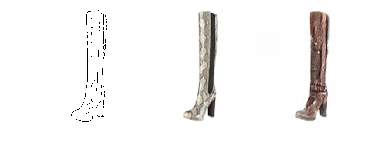

generator loss 11.477303 discriminator loss 0.43594456:  82%|███████▍ | 41000/49825 [3:09:06<40:42,  3.61it/s]

41000 0.9403128 5.338459


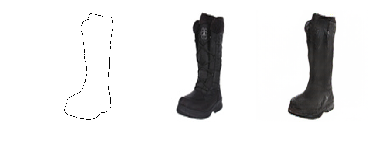

generator loss 10.906105 discriminator loss 0.4598602:  84%|████████▍ | 42000/49825 [3:13:43<36:05,  3.61it/s]

42000 0.89862 15.738771


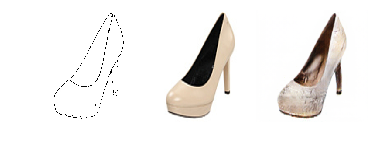

generator loss 10.380401 discriminator loss 1.712764:  86%|█████████▍ | 43000/49825 [3:18:23<31:29,  3.61it/s]

43000 0.10626193 10.582118


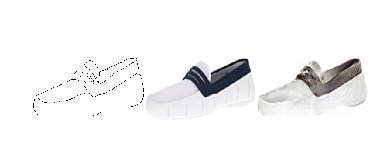

generator loss 10.572505 discriminator loss 0.6881735:  88%|████████▊ | 44000/49825 [3:23:02<26:52,  3.61it/s]

44000 1.4921281 4.834603


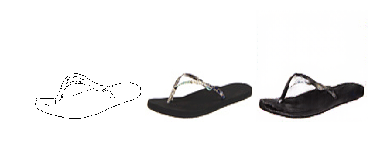

generator loss 12.072173 discriminator loss 1.2129834:  90%|█████████ | 45000/49825 [3:27:42<22:16,  3.61it/s]

45000 0.4898875 5.5049796


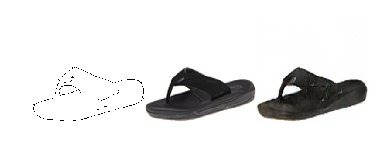

generator loss 11.242862 discriminator loss 1.6441827:  92%|█████████▏| 46000/49825 [3:32:22<17:39,  3.61it/s]

46000 1.0805998 9.20456


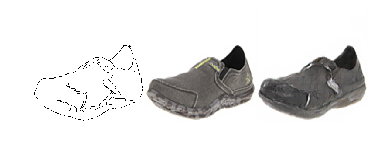

generator loss 15.415998 discriminator loss 0.18425304:  94%|████████▍| 47000/49825 [3:37:01<13:02,  3.61it/s]

47000 0.74856436 9.182091


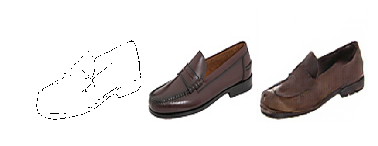

generator loss 6.722683 discriminator loss 1.5667601:  96%|██████████▌| 48000/49825 [3:41:40<08:25,  3.61it/s]

48000 0.75351465 12.12201


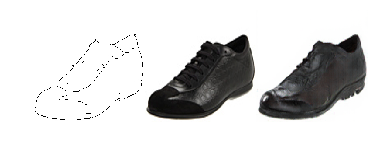

generator loss 12.821696 discriminator loss 0.46530187:  98%|████████▊| 49000/49825 [3:46:17<03:48,  3.61it/s]

49000 0.77566785 13.590488


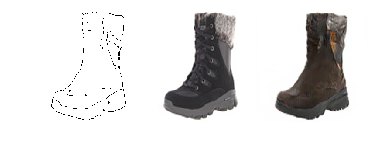

generator loss 21.824898 discriminator loss 0.20163855: 100%|█████████| 49825/49825 [3:50:06<00:00,  3.61it/s]
  0%|                                                                               | 0/49825 [00:00<?, ?it/s]

0 0.36092144 11.20617


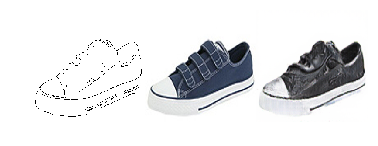

generator loss 11.00462 discriminator loss 0.58288115:   2%|▏          | 1000/49825 [04:36<3:45:21,  3.61it/s]

1000 1.0508003 6.914648


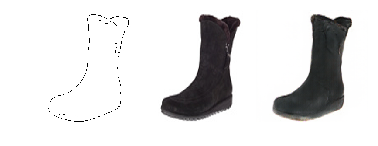

generator loss 21.120293 discriminator loss 0.12257147:   4%|▍         | 2000/49825 [09:13<3:40:40,  3.61it/s]

2000 0.26134992 8.928652


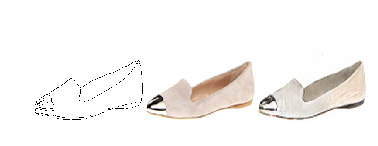

generator loss 15.247253 discriminator loss 1.1570804:   6%|▋          | 3000/49825 [13:50<3:36:03,  3.61it/s]

3000 0.24990705 16.74961


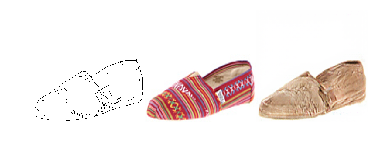

generator loss 4.511409 discriminator loss 1.3825026:   8%|▉           | 4000/49825 [18:30<3:31:57,  3.60it/s]

4000 0.6640003 4.0073233


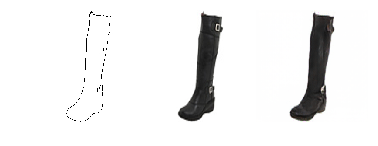

generator loss 5.424403 discriminator loss 1.3748336:  10%|█▏          | 5000/49825 [23:11<3:27:54,  3.59it/s]

5000 0.49677703 10.327849


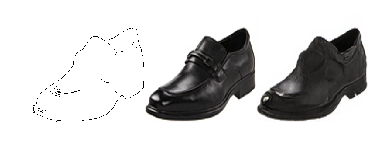

generator loss 16.520016 discriminator loss 0.10596424:  12%|█▏        | 6000/49825 [28:07<3:25:28,  3.55it/s]

6000 0.5677375 13.47835


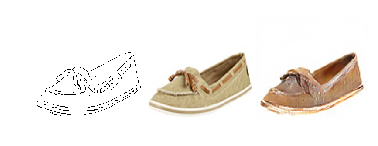

generator loss 13.172855 discriminator loss 0.65284306:  14%|█▍        | 7000/49825 [32:55<3:21:27,  3.54it/s]

7000 0.9222929 8.144942


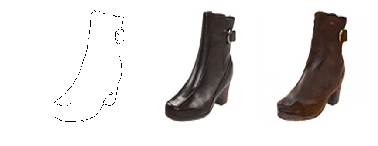

generator loss 12.739834 discriminator loss 0.642766:  16%|█▉          | 8000/49825 [37:33<3:16:20,  3.55it/s]

8000 0.41799772 13.0342865


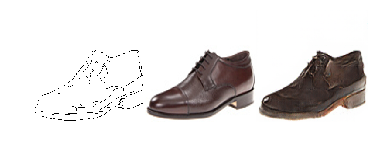

generator loss 18.168251 discriminator loss 0.7243882:  18%|█▉         | 9000/49825 [42:11<3:11:24,  3.55it/s]

9000 0.6048097 13.94043


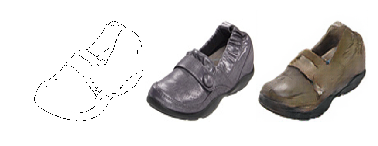

generator loss 13.096451 discriminator loss 0.30090362:  20%|█▊       | 10000/49825 [46:52<3:06:42,  3.56it/s]

10000 0.1306325 25.30364


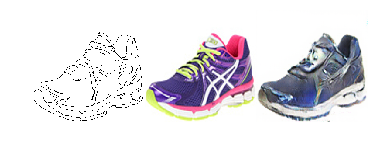

generator loss 26.627499 discriminator loss 0.0552801:  22%|██▏       | 11000/49825 [51:32<3:01:54,  3.56it/s]

11000 1.1533023 9.652311


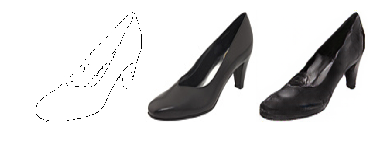

generator loss 6.112487 discriminator loss 0.5457907:  24%|██▋        | 12000/49825 [56:10<2:57:05,  3.56it/s]

12000 0.40345955 11.129343


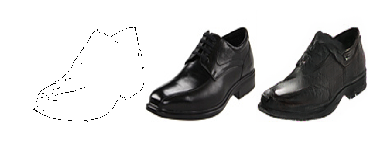

generator loss 8.174015 discriminator loss 0.3968901:  26%|██▎      | 13000/49825 [1:00:51<2:52:24,  3.56it/s]

13000 0.94119847 8.377372


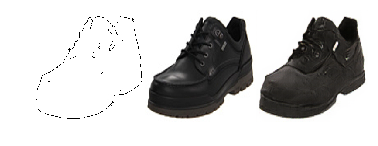

generator loss 20.683311 discriminator loss 0.15606615:  28%|█▉     | 14000/49825 [1:05:31<2:47:39,  3.56it/s]

14000 0.6813806 16.709822


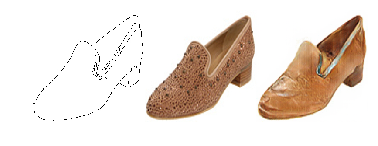

generator loss 12.056451 discriminator loss 0.12182495:  30%|██     | 15000/49825 [1:10:11<2:42:57,  3.56it/s]

15000 1.8212769 15.524635


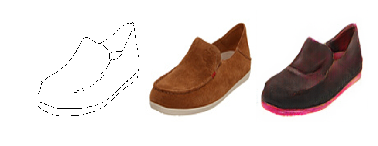

generator loss 13.3673315 discriminator loss 0.09560722:  32%|█▉    | 16000/49825 [1:14:49<2:38:10,  3.56it/s]

16000 0.57236135 10.518096


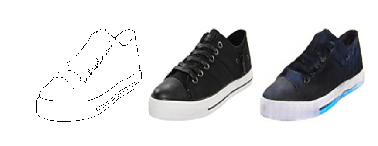

generator loss 25.835844 discriminator loss 0.26681262:  34%|██▍    | 17000/49825 [1:19:26<2:33:23,  3.57it/s]

17000 0.6487019 13.602441


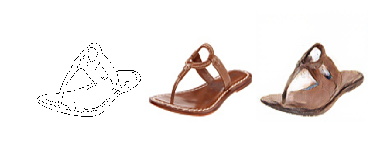

generator loss 13.48217 discriminator loss 1.2766942:  36%|███▎     | 18000/49825 [1:24:07<2:28:44,  3.57it/s]

18000 0.39186367 15.712776


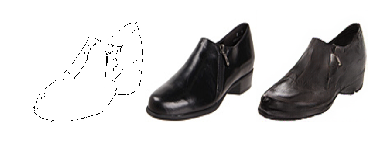

generator loss 9.1752615 discriminator loss 0.1615645:  38%|███     | 19000/49825 [1:28:49<2:24:05,  3.57it/s]

19000 0.6287486 10.1767845


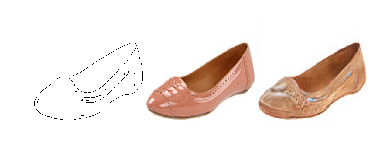

generator loss 12.784752 discriminator loss 0.14927462:  40%|██▊    | 20000/49825 [1:33:31<2:19:28,  3.56it/s]

20000 0.6247685 7.310422


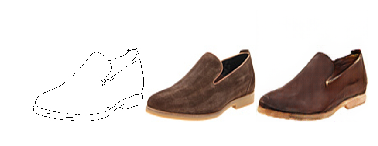

generator loss 23.62677 discriminator loss 0.08756848:  42%|███▎    | 21000/49825 [1:38:12<2:14:47,  3.56it/s]

21000 0.6966088 9.385294


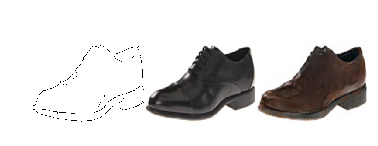

generator loss 13.670851 discriminator loss 0.5435507:  44%|███▌    | 22000/49825 [1:42:52<2:10:06,  3.56it/s]

22000 0.7462935 10.555453


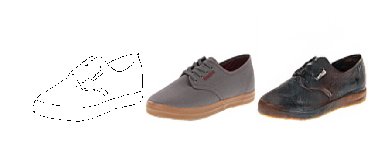

generator loss 28.27204 discriminator loss 0.20431426:  46%|███▋    | 23000/49825 [1:47:31<2:05:24,  3.57it/s]

23000 2.0615633 7.535357


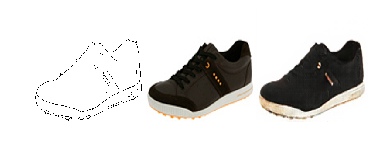

generator loss 5.768944 discriminator loss 0.6692797:  48%|████▎    | 24000/49825 [1:52:11<2:00:43,  3.57it/s]

24000 0.35064113 9.319597


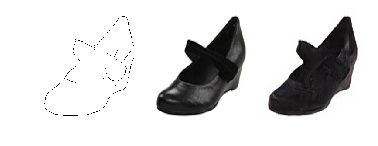

generator loss 11.337261 discriminator loss 0.61823416:  50%|███▌   | 25000/49825 [1:56:52<1:56:03,  3.56it/s]

25000 0.8593424 12.2008915


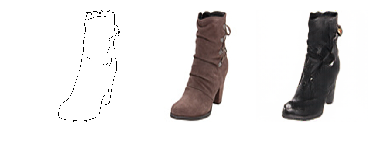

generator loss 6.9746556 discriminator loss 1.9038339:  52%|████▏   | 26000/49825 [2:01:32<1:51:22,  3.57it/s]

26000 0.14844939 10.080847


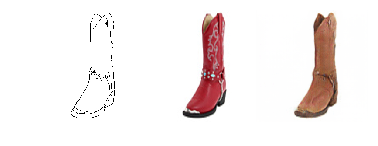

generator loss 11.517334 discriminator loss 1.0901546:  54%|████▎   | 27000/49825 [2:06:13<1:46:42,  3.57it/s]

27000 1.3346214 9.820256


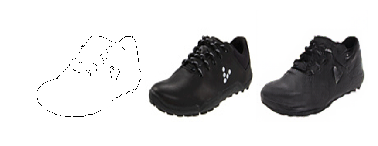

generator loss 16.479471 discriminator loss 0.53127635:  56%|███▉   | 28000/49825 [2:10:53<1:42:01,  3.57it/s]

28000 0.59199667 7.428269


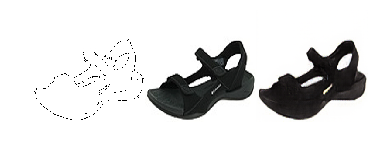

generator loss 11.914558 discriminator loss 0.6610569:  58%|████▋   | 29000/49825 [2:15:33<1:37:20,  3.57it/s]

29000 0.08875674 20.39954


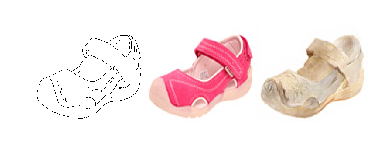

generator loss 10.891889 discriminator loss 0.57916087:  60%|████▏  | 30000/49825 [2:20:16<1:32:41,  3.56it/s]

30000 0.86951333 17.635712


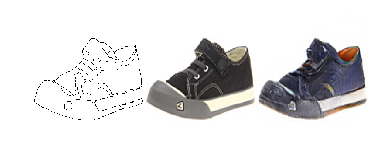

generator loss 27.197462 discriminator loss 0.091583684:  62%|███▋  | 31000/49825 [2:25:00<1:28:03,  3.56it/s]

31000 1.0052457 7.6994386


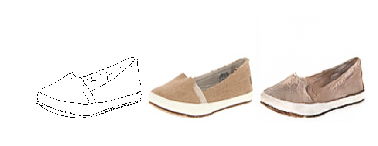

generator loss 13.989814 discriminator loss 0.19568655:  64%|████▍  | 32000/49825 [2:29:44<1:23:24,  3.56it/s]

32000 0.977885 6.539733


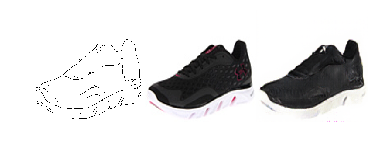

generator loss 8.596199 discriminator loss 4.3667994:  66%|█████▉   | 33000/49825 [2:34:27<1:18:44,  3.56it/s]

33000 1.2746779 17.879189


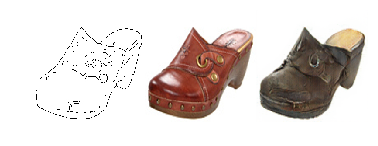

generator loss 17.35501 discriminator loss 0.5062038:  68%|██████▏  | 34000/49825 [2:39:09<1:14:04,  3.56it/s]

34000 0.7567769 14.092706


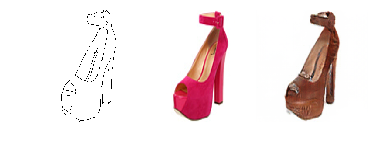

generator loss 22.23255 discriminator loss 0.26902458:  70%|█████▌  | 35000/49825 [2:43:53<1:09:25,  3.56it/s]

35000 0.9117317 10.9637575


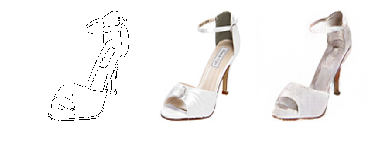

generator loss 8.68862 discriminator loss 1.4203188:  72%|███████▏  | 36000/49825 [2:48:33<1:04:43,  3.56it/s]

36000 0.78904945 8.943313


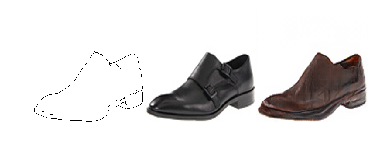

generator loss 16.7583 discriminator loss 1.5861285:  74%|███████▍  | 37000/49825 [2:53:16<1:00:03,  3.56it/s]

37000 1.2474114 10.910316


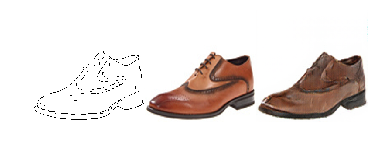

generator loss 18.080502 discriminator loss 0.08515099:  76%|██████▊  | 38000/49825 [2:57:58<55:22,  3.56it/s]

38000 1.521983 7.2901154


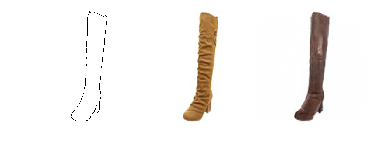

generator loss 13.103818 discriminator loss 3.0440464:  78%|███████▊  | 39000/49825 [3:02:40<50:42,  3.56it/s]

39000 0.0449691 21.321104


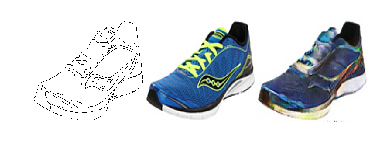

generator loss 7.147582 discriminator loss 0.28670424:  80%|████████  | 40000/49825 [3:07:24<46:01,  3.56it/s]

40000 0.52561176 9.429821


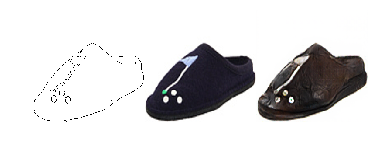

generator loss 5.2023134 discriminator loss 0.60591316:  82%|███████▍ | 41000/49825 [3:12:06<41:20,  3.56it/s]

41000 0.4160036 11.412827


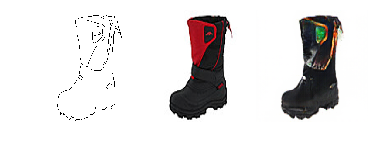

generator loss 14.88941 discriminator loss 0.13348697:  84%|████████▍ | 42000/49825 [3:16:46<36:39,  3.56it/s]

42000 0.6551085 5.933913


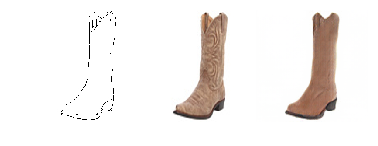

generator loss 13.763651 discriminator loss 0.35419762:  86%|███████▊ | 43000/49825 [3:21:29<31:58,  3.56it/s]

43000 0.9552517 12.481602


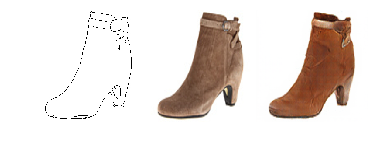

generator loss 8.240671 discriminator loss 0.10424013:  88%|████████▊ | 44000/49825 [3:26:11<27:17,  3.56it/s]

44000 0.61214006 13.213507


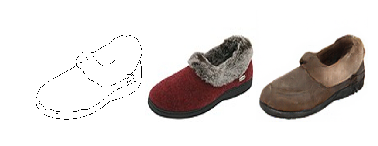

generator loss 10.070948 discriminator loss 1.4181764:  90%|█████████ | 45000/49825 [3:30:53<22:36,  3.56it/s]

45000 0.7358911 29.588928


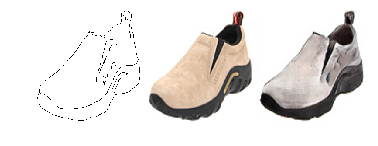

generator loss 37.977463 discriminator loss 0.044071686:  92%|███████▍| 46000/49825 [3:35:39<17:55,  3.55it/s]

46000 0.42856476 13.052777


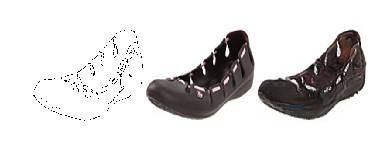

generator loss 17.0301 discriminator loss 0.17642444:  94%|██████████▍| 47000/49825 [3:40:24<13:14,  3.55it/s]

47000 1.2086658 13.000414


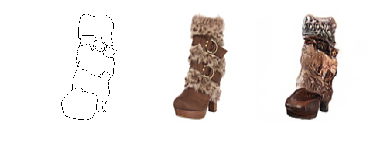

generator loss 30.064419 discriminator loss 0.026003554:  96%|███████▋| 48000/49825 [3:45:05<08:33,  3.55it/s]

48000 0.0684465 10.929001


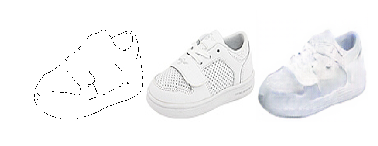

generator loss 14.399334 discriminator loss 0.0983666:  98%|█████████▊| 49000/49825 [3:49:45<03:52,  3.55it/s]

49000 0.049676977 18.030977


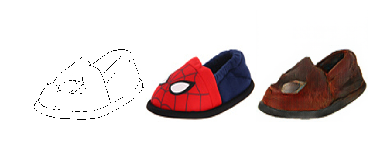

generator loss 18.960417 discriminator loss 0.83545727: 100%|█████████| 49825/49825 [3:53:37<00:00,  3.55it/s]


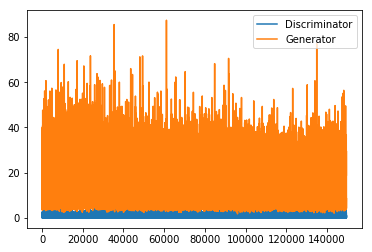

In [13]:
sess = tf.Session()
# sess.run(tf.global_variables_initializer())
saver.restore(sess=sess,save_path='./pix2pix_diy-100000')
loss = {'d': [], 'g': []}
epoch =3
for j in range(epoch):
    bar = tqdm(range(49825))

    np.random.shuffle(images)
    for i in bar:
        k = i % len(images)
        data_img = imread(images[i])
        data_img = (data_img / 255. - 0.5) * 2 #这个你可以认为把数据变换到了-1到1
        label = data_img[:, WIDTH:, :]
        edge_img = data_img[:, :WIDTH, :]
    #     X_batch, Y_batch = X_all[k:k + batch_size, :, :, :], Y_all[k:k + batch_size, :, :, :]

        _, d_ls = sess.run([optimizer_d, loss_d], feed_dict={X: [edge_img], Y: [label]})
        _, g_ls = sess.run([optimizer_g, loss_g], feed_dict={X: [edge_img], Y: [label]})

        loss['d'].append(d_ls)
        loss['g'].append(g_ls)

        if i % 1000 == 0:
            print(i, d_ls, g_ls)
            test_img = imread(images[k])
            test_img = (test_img / 255. - 0.5) * 2
            label = test_img[:, WIDTH:, :]
            edge_img = test_img[:, :WIDTH, :]
            gen_imgs = sess.run(g, feed_dict={X: [edge_img]})
            result = np.zeros([HEIGHT, WIDTH * 3, 3])
            result[:, :WIDTH, :] = (edge_img + 1) / 2
            result[:, WIDTH: 2 * WIDTH, :] = (label + 1) / 2
            result[:, 2 * WIDTH:, :] = (gen_imgs[0] + 1) / 2
            plt.axis('off')
            plt.imshow(result)
            imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), result)
            plt.show()

        bar.set_description("generator loss %s discriminator loss %s" % (str(g_ls),str(d_ls)))

plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.show()

In [14]:

saver.save(sess, './model/pix2pix_diy', global_step=100000)

'./pix2pix_diy-100000'